In [13]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pylab
import mysql.connector as sql
import geopandas as gpd
from shapely.geometry import Point
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_extraction import FeatureHasher
from feature_engine.categorical_encoders import MeanCategoricalEncoder, OneHotCategoricalEncoder
from feature_engine import missing_data_imputers as mdi
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import xgboost as xgb
from xgboost import plot_tree


import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.5f}'.format

In [14]:
#db_connection = sql.connect(host='Samuels-MacBook-Air.local', database='realestate_AVM',
#                            user='root', password='Building9Floor')

In [15]:
#df = pd.read_sql('SELECT * FROM properties;', con=db_connection)
#df.head()

In [16]:
raw_data = pd.read_csv('Data/house_data_details_eda.csv')
df = raw_data.copy()
gdf = gpd.GeoDataFrame(df, geometry=[Point(xy) for xy in zip(df.longitude, df.latitude)])
gdf.crs = {'init': 'epsg:4326'}

In [17]:
#Split the dataset into train and test set
targets = gdf['sale_price']
inputs = gdf.drop(['sale_price'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(inputs, targets, test_size=.2, random_state=24)

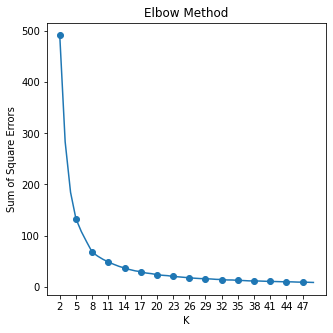

In [18]:
#Cluster the properties by location
ssd = []

for i in range(2,50):
    
    kmeans = KMeans(n_clusters=i, init ='k-means++')
    kmeans.fit_predict(x_train[['latitude', 'longitude']])
    ssd.append(ssd.append(kmeans.inertia_))
    
ssd = ssd[::2]


#Elbow method to determine the optimal number for k
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(list(range(2,50)), ssd, marker='o', markevery=3)
plt.title('Elbow Method')
plt.xlabel('K')
plt.ylabel('Sum of Square Errors')
ax.set(xticks=range(2,50,3));

In [19]:
#8 seems like the optimal number of clusters
kmeans = KMeans(n_clusters=8, init='k-means++')
x_train['geolocation_cluster'] = kmeans.fit_predict(x_train[['latitude', 'longitude']])
x_test['geolocation_cluster'] = kmeans.predict(x_test[['latitude', 'longitude']])

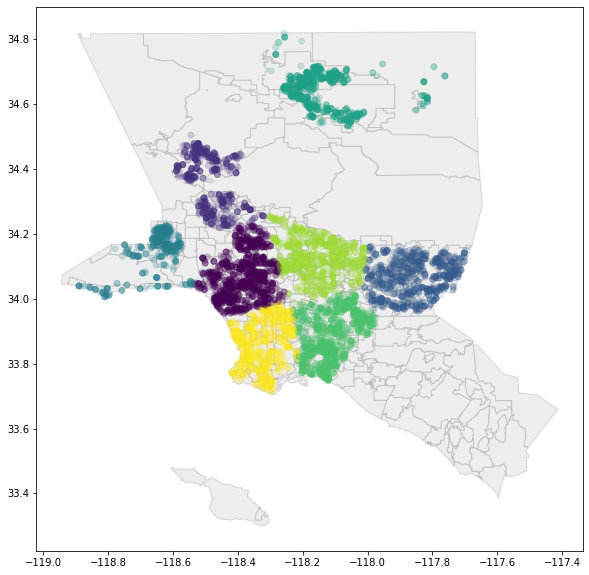

In [20]:
#Plot the data point on a map of Los Angeles
fig, ax = plt.subplots(figsize=(10,10))

la_full = gpd.read_file('LACounty/l.a. county neighborhood (v6).shp')
la_full.plot(ax=ax, alpha=0.4, edgecolor='darkgrey', color='lightgrey', aspect=1,zorder=1)

#Conver x_train df into geopandas df so that we can visualize it
temp_plot = gpd.GeoDataFrame(x_train.copy(), geometry=[Point(xy) for xy in zip(x_train.longitude, x_train.latitude)])
temp_plot.plot(ax=ax, aspect=1, c=temp_plot['geolocation_cluster'], alpha=0.2, linewidth=0.8, zorder=2);

In [21]:
#Find the distance between each point and each observation in order to smooth out prices that lie on the border of clusters
kc = kmeans.cluster_centers_

for i in range(len(kc)):
    x_train['distance_'+ str(i)] = np.sqrt((x_train.latitude-kc[i][0])**2+(x_train.longitude-kc[i][1])**2)
    x_test['distance_'+ str(i)] = np.sqrt((x_test.latitude-kc[i][0])**2+(x_test.longitude-kc[i][1])**2)
    
#Drop the latitude and longitude
x_train.drop(['latitude', 'longitude', 'geolocation_cluster', 'geometry'], axis=1, inplace=True)
x_test.drop(['latitude', 'longitude', 'geolocation_cluster', 'geometry'], axis=1, inplace=True)

In [22]:
#Dummy encode the categorical variables
ohe_encoder = OneHotCategoricalEncoder(variables=['crime_index', 'school_quality'])

ohe_encoder.fit(x_train)

x_train = ohe_encoder.transform(x_train)
x_test = ohe_encoder.transform(x_test)

In [23]:
from category_encoders.hashing import HashingEncoder

he = HashingEncoder(cols=['zoning'], n_components=5).fit(x_train, y_train)

x_train = he.transform(x_train)
x_test = he.transform(x_test)
x_train.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 7719 entries, 0 to 7718
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   col_0                         7719 non-null   int64  
 1   col_1                         7719 non-null   int64  
 2   col_2                         7719 non-null   int64  
 3   col_3                         7719 non-null   int64  
 4   col_4                         7719 non-null   int64  
 5   home_size                     7719 non-null   float64
 6   lot_size                      7719 non-null   float64
 7   sex_offenders                 7719 non-null   int64  
 8   enviornmental_hazards         7719 non-null   int64  
 9   natural_disasters             7719 non-null   int64  
 10  bedrooms                      7719 non-null   float64
 11  bathrooms                     7719 non-null   float64
 12  cpi                           7719 non-null   float64


### XGBoost Model

In [82]:
#Optimize the objective function with hyperopt for xgboost

#Definte the search spaces
space = {
            'base_score' : [.5, .15, .25, .5, .75, .85, .95],
            'booster' : ['gbtree', 'dart'],
            'importance_type' : ['weight', 'gain', 'cover', 'total_gain', 'total_cover'],
            'learning_rate' : [None, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4],
            'max_delta_step' : [None, 1, 2, 3, 4, 5],
            'num_parallel_tree' : [None, 1, 2, 3, 4, 5],
    
         }

#Objective function
cv = KFold(n_splits=10, random_state=24, shuffle=True)

def acc_model(params):
    
    depth = int(params['max_depth'])
    est= int(params['n_estimators'])
   
    regressor = xgb.XGBRegressor(random_state=24,
                                 base_score= params['base_score'],
                                 booster= params['booster'], 
                                 colsample_bylevel= params['colsample_bylevel'], 
                                 colsample_bynode= params['colsample_bynode'],
                                 colsample_bytree= params['colsample_bytree'], 
                                 gamma= params['gamma'], 
                                 importance_type= params['importance_type'],
                                 learning_rate= params['learning_rate'],
                                 max_delta_step= params['max_delta_step'], 
                                 max_depth= depth, 
                                 min_child_weight= params['min_child_weight'],
                                 n_estimators=est, 
                                 num_parallel_tree= params['num_parallel_tree'], 
                                 reg_lambda= params['reg_lambda'])
                                 
    return -cross_val_score(regressor, x_train, y_train, scoring='neg_mean_absolute_error').mean()

#Define the search space
param_space = { 
                'base_score' : hp.choice('base_score', space.get('base_score')),
                'booster': hp.choice('booster', space.get('booster')),
                'colsample_bylevel': hp.uniform('colsample_bylevel', 0, 1),
                'colsample_bynode': hp.uniform('colsample_bynode', 0, 1),
                'colsample_bytree': hp.uniform('colsample_bytree', 0, 1),
                'gamma': hp.uniform('gamma',1,15),
                'importance_type': hp.choice('importance_type', space.get('importance_type')),
                'learning_rate': hp.choice('learning_rate', space.get('learning_rate')),
                'max_delta_step': hp.choice('max_delta_step', space.get('max_delta_step')),
                'max_depth': hp.quniform('max_depth',1,10,1),
                'min_child_weight': hp.uniform('min_child_weight', 1, 100),
                'n_estimators': hp.quniform('n_estimators', 25,500,1),
                'num_parallel_tree': hp.choice('num_parallel_tree', space.get('num_parallel_tree')),
                'reg_lambda': hp.uniform('reg_lambda',1,15)
            }

best = 100

def f(params):
    global best
    acc = acc_model(params)
    if acc < best:
        best = acc
        print ('new best:', best, params) 
        
    return {'loss': acc, 'status': STATUS_OK}

trials = Trials()
best_params = fmin(f, param_space, algo=tpe.suggest, max_evals=25, trials=trials)
print ('best:')
print (best_params)

new best:                                             
0.850945096949532                                     
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.828004662802383, 'colsample_bynode': 0.42155336739833615, 'colsample_bytree': 0.15940326118586523, 'gamma': 8.933082613659582, 'importance_type': 'total_cover', 'learning_rate': 0.4, 'max_delta_step': None, 'max_depth': 5.0, 'min_child_weight': 63.30723744512404, 'n_estimators': 401.0, 'num_parallel_tree': 4, 'reg_lambda': 11.406168342316029}
new best:                                                                      
0.8149979134447467                                                             
{'base_score': 0.15, 'booster': 'gbtree', 'colsample_bylevel': 0.8178556286508871, 'colsample_bynode': 0.38723611765681876, 'colsample_bytree': 0.4127571654098665, 'gamma': 11.159550621355864, 'importance_type': 'weight', 'learning_rate': 0.25, 'max_delta_step': None, 'max_depth': 9.0, 'min_child_weight': 35.03042802510

In [ ]:
#Create a function that can transform the parameters into a readable object for the XGBRegressor
def return_proper_params(best):
    temp = best.copy()
    temp['max_depth'] = int(temp['max_depth'])
    temp['n_estimators'] = int(temp['n_estimators'])
    
    for param in space:
        temp[param] = space.get(param)[best.get(param)]
        
    return temp


best_params = return_proper_params(best_params)
best_params

In [24]:
#Use this code to store the best_params so that you don't have to rerun the hyperoptimization function
import pickle

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

#save_obj(best_params, 'best_params')
best_params = load_obj('best_params')
best_params

{'base_score': 0.5,
 'booster': 'dart',
 'colsample_bylevel': 0.9939829548484214,
 'colsample_bynode': 0.07023436783259435,
 'colsample_bytree': 0.6019411675203766,
 'gamma': 1.0715633962431634,
 'importance_type': 'gain',
 'learning_rate': 0.35,
 'max_delta_step': 5,
 'max_depth': 10,
 'min_child_weight': 42.10578455864081,
 'n_estimators': 499,
 'num_parallel_tree': 3,
 'reg_lambda': 7.750604437769053}

In [25]:
#Write a function that calculates mape
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


regressor = xgb.XGBRegressor(random_state=24,
                             base_score= best_params['base_score'],
                             booster= best_params['booster'], 
                             colsample_bylevel= best_params['colsample_bylevel'], 
                             colsample_bynode= best_params['colsample_bynode'],
                             colsample_bytree= best_params['colsample_bytree'], 
                             gamma= best_params['gamma'], 
                             importance_type= best_params['importance_type'],
                             learning_rate= best_params['learning_rate'],
                             max_delta_step= best_params['max_delta_step'], 
                             max_depth= best_params['max_depth'], 
                             min_child_weight= best_params['min_child_weight'],
                             n_estimators= best_params['n_estimators'], 
                             num_parallel_tree= best_params['num_parallel_tree'], 
                             reg_lambda= best_params['reg_lambda'])

regressor.fit(x_train, y_train)

# Use this code when using the log transformer
# Need to back transform the target variable
test_predictions = np.exp(regressor.predict(x_test))
y_test_transformed = np.exp(y_test)


score = np.round(mean_absolute_percentage_error(y_test_transformed, test_predictions),3)
print(f'XGBoost mape on testing set: {score}%')

XGBoost mape on testing set: 101.428%


In [90]:
#MAPE for the train set
train_predictions = np.exp(regressor.predict(x_train))
y_train_transformed = np.exp(y_train)

score = np.round(mean_absolute_percentage_error(y_train_transformed, train_predictions),3)
print(f'XGBoost mape on training set: {score}%')

XGBoost mape on training set: 54.61%


In [83]:
#Let's examine the residuals
#residuals = x_train.copy()
#residuals['residuals'] = np.log(abs(y_train - predictions_train))
#residuals.sort_values(by='residuals', ascending=False, inplace=True)
#residuals

TypeError: expected str, bytes or os.PathLike object, not GeoDataFrame

<Figure size 432x288 with 0 Axes>

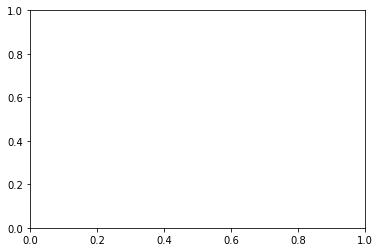

In [31]:
plt.figure()
plot_tree(regressor, x_train, y_train)
plt.show()

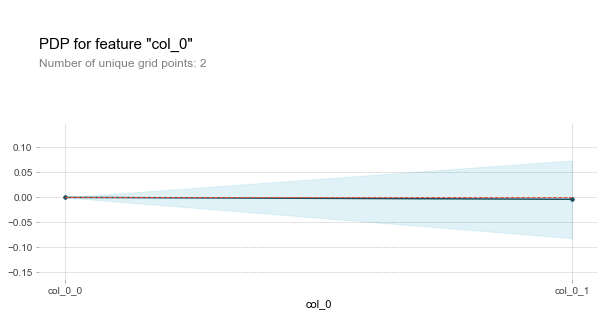

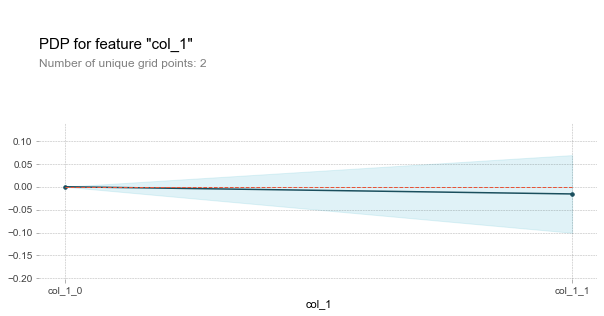

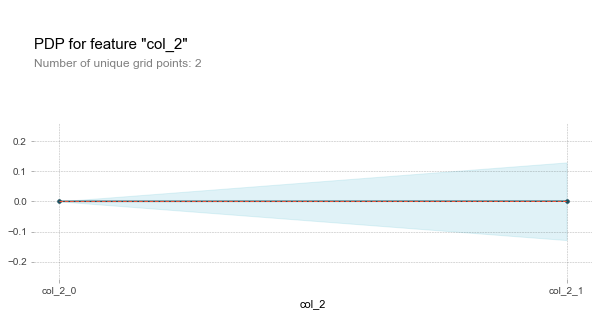

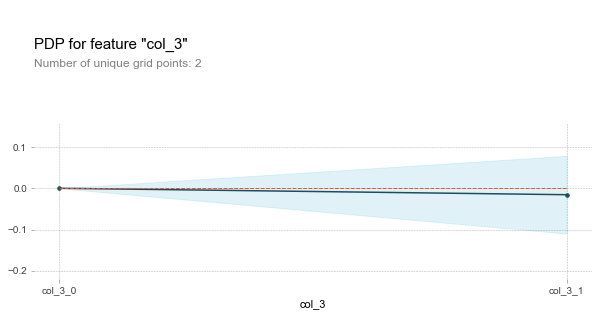

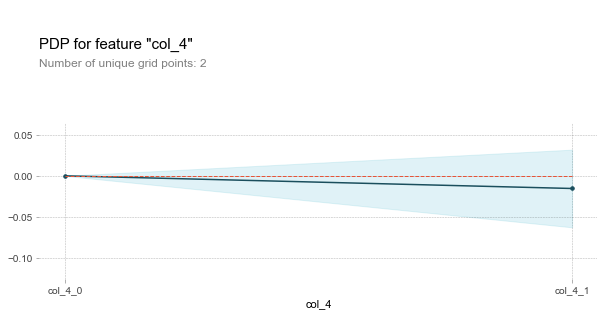

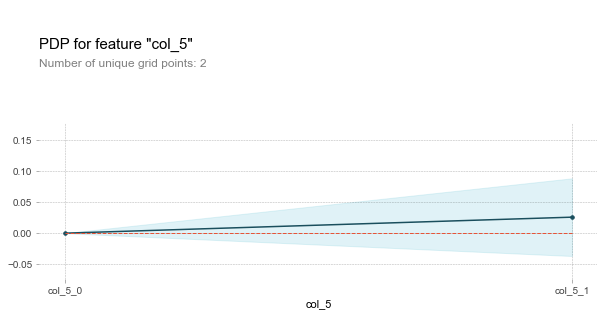

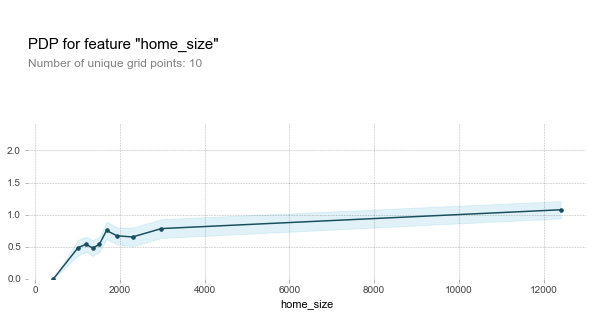

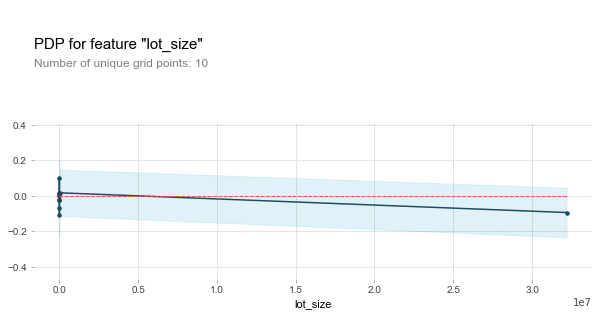

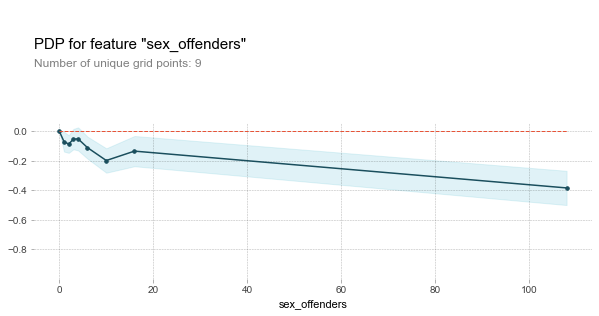

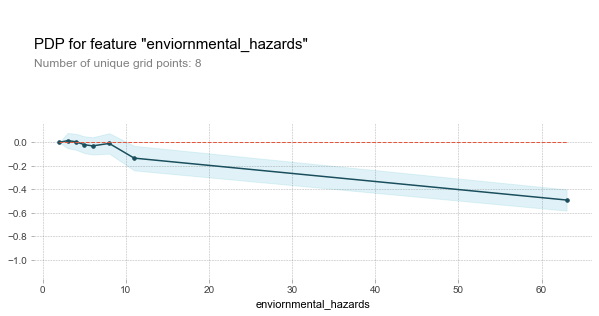

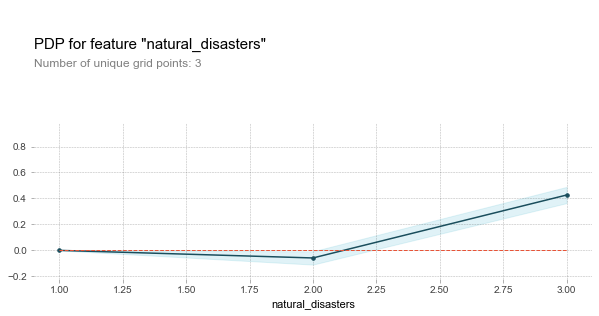

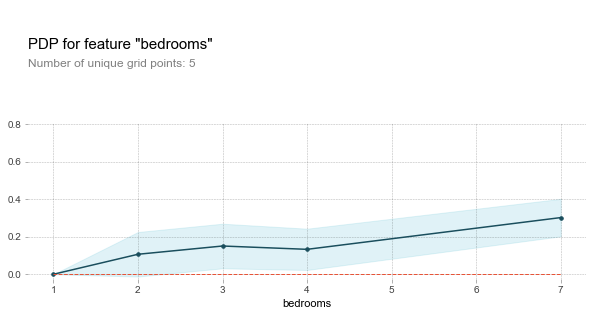

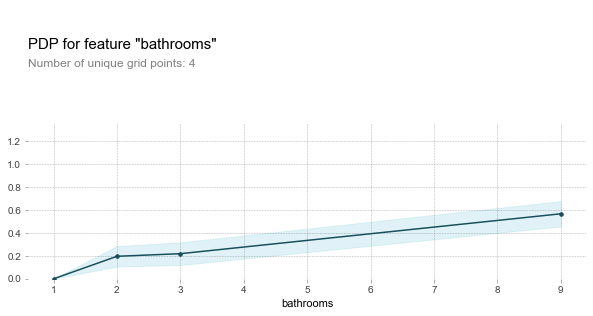

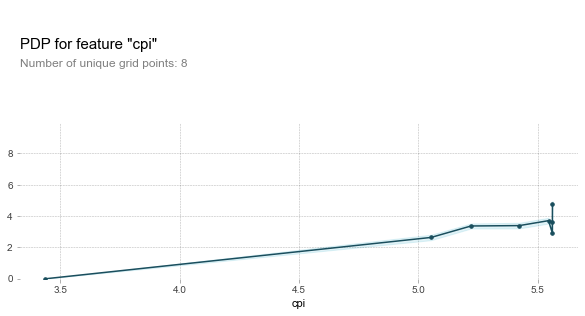

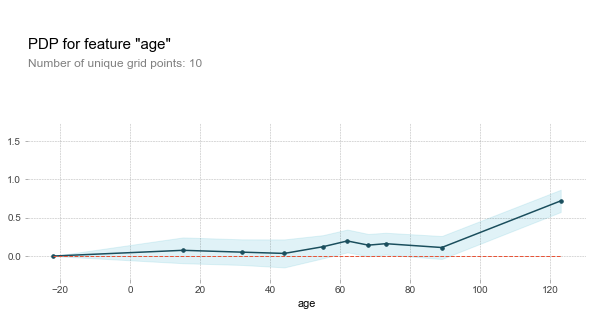

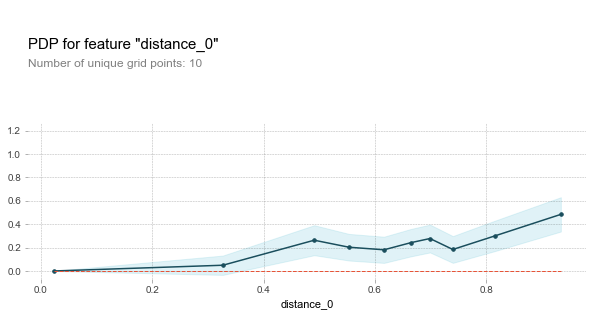

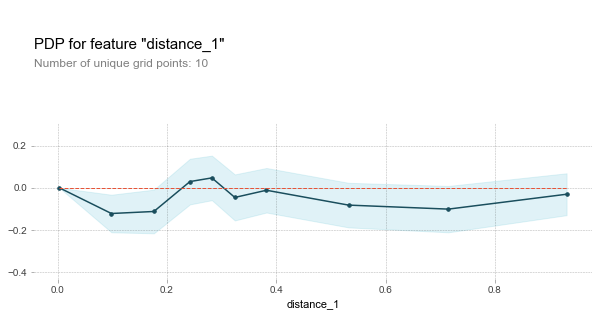

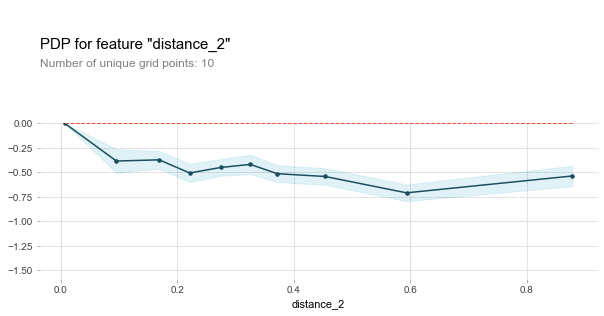

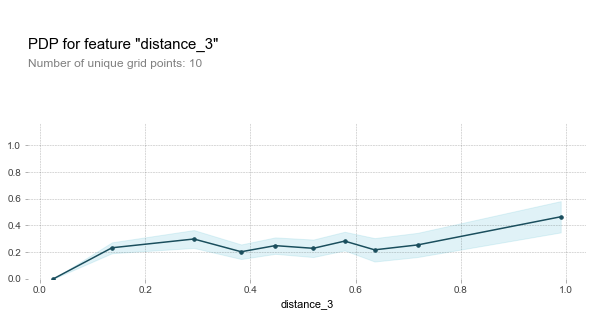

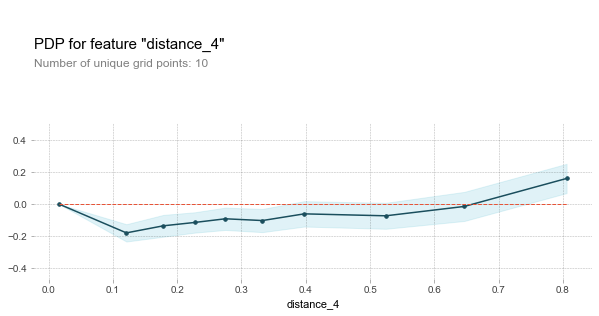

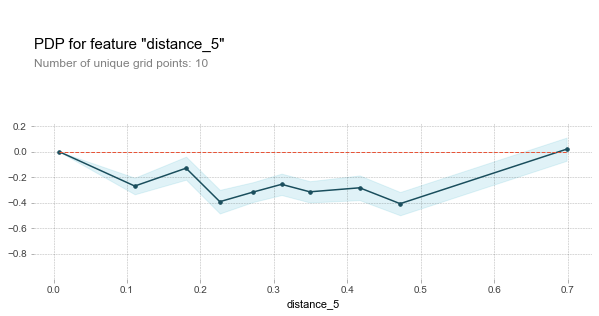

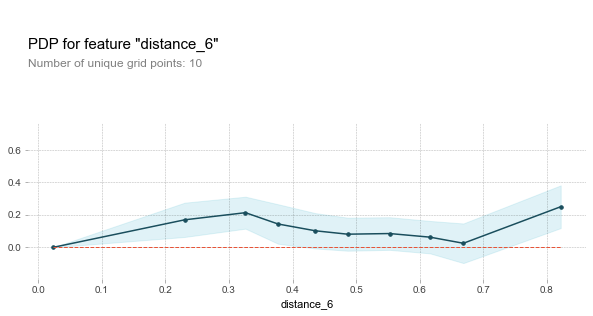

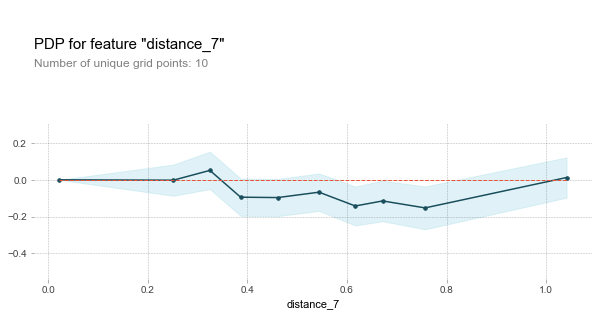

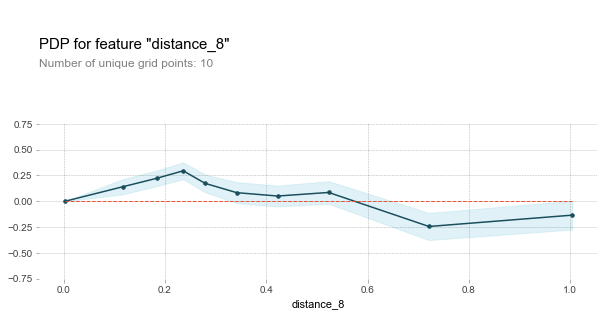

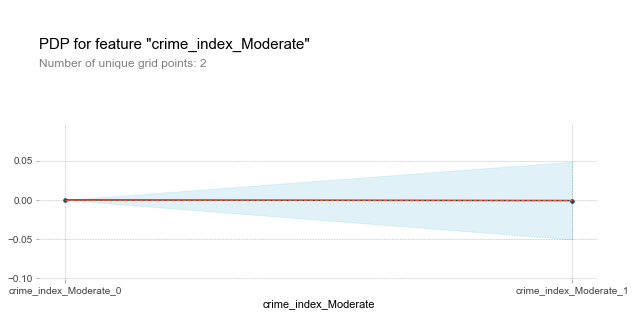

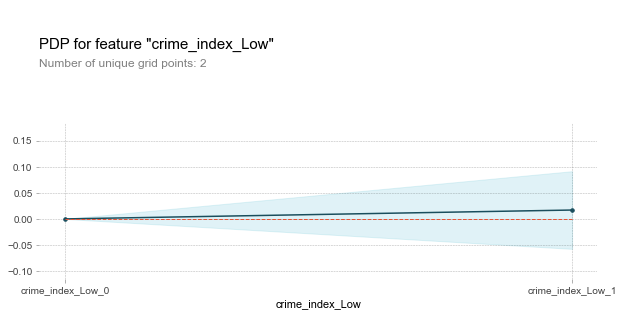

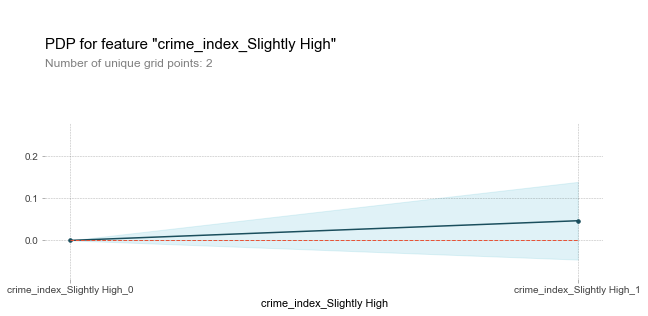

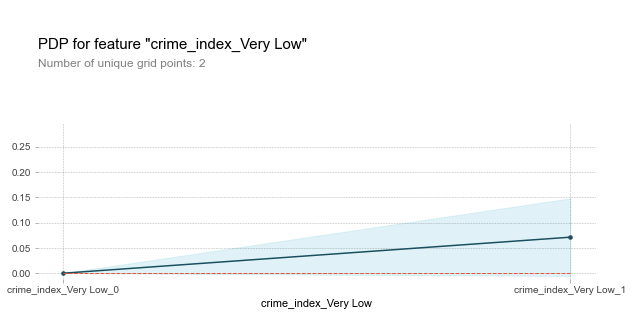

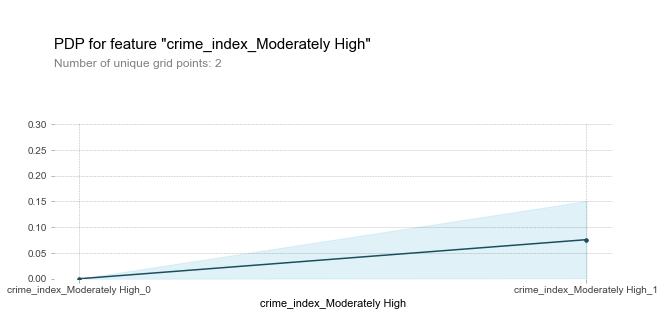

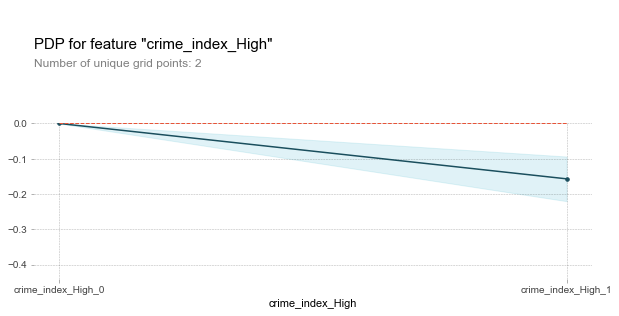

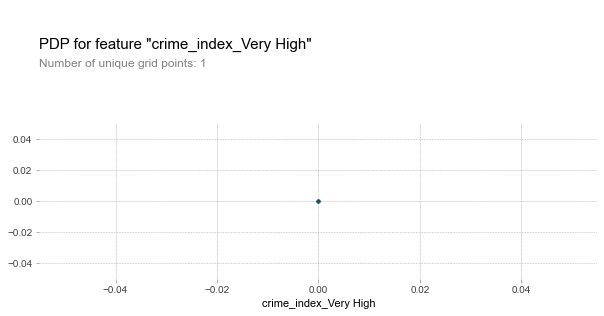

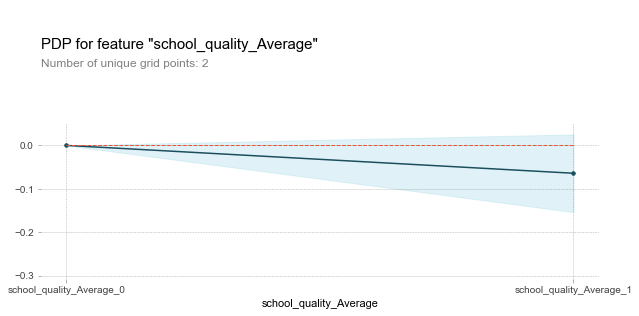

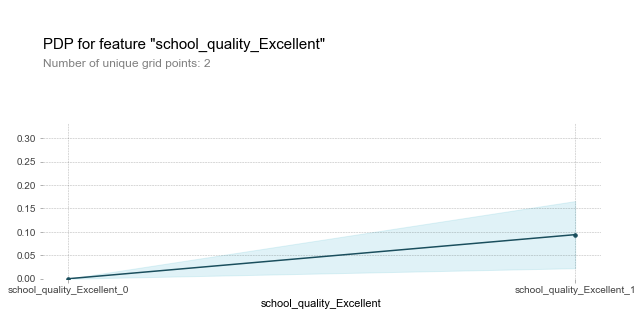

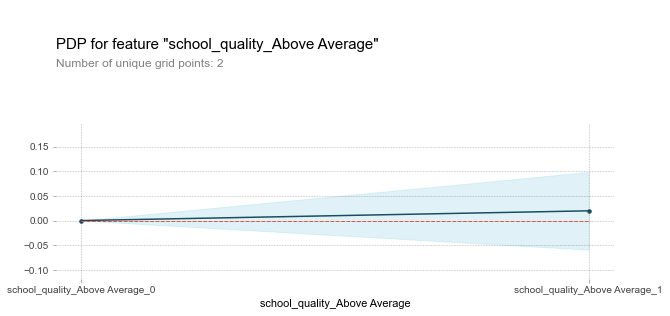

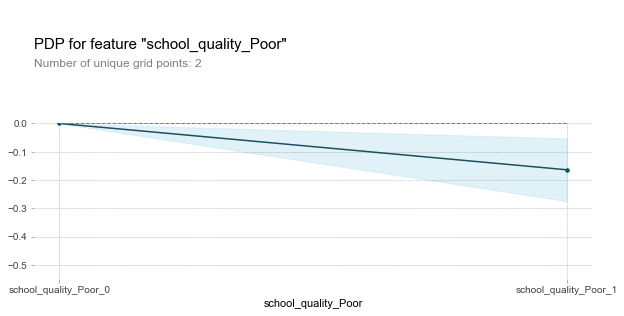

In [20]:
from pdpbox import pdp

for col in x_train.columns:    
    # Create the data that we will plot
    pdp_goals = pdp.pdp_isolate(model=regressor, dataset=pd.DataFrame(x_test), model_features=x_test.columns, feature=col)

    # plot it
    pdp.pdp_plot(pdp_goals, col, figsize=(10,5))
    plt.show()

### Random Forest Model

In [33]:
#Optimize the objective function with hyperopt for Random Forest
def acc_model(params):
    est= int(params['n_estimators'])
    feat= int(params['max_features'])
    leaf= int(params['min_samples_leaf'])
    rf = RandomForestRegressor(n_estimators=est, max_features=feat, min_samples_leaf=leaf)
    return cross_val_score(rf, x_train, y_train).mean()

#Define the search space
param_space = {
    
               'n_estimators': hp.quniform('n_estimators', 25,500,1), 
               'max_features': hp.quniform('max_features',1,40,1), 
               'min_samples_leaf': hp.quniform('min_samples_leaf',1,3,1)
            }

best = 0

def f(params):
    global best
    acc = acc_model(params)
    if acc > best:
        best = acc
        print ('new best:', best, params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best_params = fmin(f, param_space, algo=tpe.suggest, max_evals=100, trials=trials)
print ('best:')
print (best_params)

new best:                                              
0.7914587038612527                                     
{'max_features': 15.0, 'min_samples_leaf': 3.0, 'n_estimators': 157.0}
new best:                                                                         
0.7948474183568888                                                                
{'max_features': 13.0, 'min_samples_leaf': 2.0, 'n_estimators': 390.0}            
new best:                                                                         
0.7990082216606973                                                                
{'max_features': 18.0, 'min_samples_leaf': 1.0, 'n_estimators': 261.0}            
new best:                                                                          
0.7999610730501765                                                                 
{'max_features': 24.0, 'min_samples_leaf': 1.0, 'n_estimators': 475.0}             
100%|██████████| 100/100 [38:39<00:00, 23.20s/trial, best loss: -0.

In [32]:
rf = RandomForestRegressor(n_estimators=494,
                           max_features=23,
                           min_samples_leaf=1,
                           random_state=24)

rf.fit(x_train, y_train)
predictions = rf.predict(x_test)


# Use this code when using the log transformer
# Need to back transform the target variable

'''
predictions = np.exp(rf.predict(x_test))
y_test = np.exp(y_test)

'''

score = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Random Forest rmse score: {score}')

Random Forest Score rmse: 169744.62318410276


## Extra tools

In [119]:
def diagnostic_plots(df, variable, labels):
    
    plt.figure(figsize=(20,6))
    plt.subplot(1,3,1)
    df[variable].hist()
    plt.ticklabel_format(style='plain', axis='x')
    
    plt.subplot(1,3,2)
    stats.probplot(df[variable], dist='norm', plot=pylab)
    plt.title(col)
    plt.ticklabel_format(style='plain', axis='x')
    
    plt.subplot(1,3,3)
    plt.scatter(df[variable], labels)
    plt.title(col)
    plt.ticklabel_format(style='plain', axis='x')

In [154]:
#This function helps determine which variables are correlated

def correlation(dataset, threshold):
    
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            # we are interested in absolute coeff value
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    
    return col_corr


corr_features = correlation(x_train, 0.8)
print('correlated features: ', len(set(corr_features)))
print(corr_features)

correlated features:  2


In [164]:
residuals = x_train.copy()
residuals['residuals'] = abs(y_train - predictions)
x_test.sort_values(by='residuals', ascending=False, inplace=True)
x_test

,home_size,lot_size,parcel_number,enviornmental_hazards,natural_disasters,bathrooms,month,year,property_type_Single Family Residence,property_type_Condominium,"property_type_Duplex (2 units, any combination)",property_type_Planned Unit Development (PUD),"property_type_Triplex (3 units, any combination)",property_type_Apartment house (5+ units),"property_type_Quadplex (4 Units, Any Combination)",crime_index_Low,crime_index_Moderate,crime_index_Slightly High,crime_index_Very Low,crime_index_Moderately High,crime_index_High,school quality_Average,school quality_Excellent,school quality_Above Average,school quality_Poor,geolocation_cluster,residuals
3667,14765.00000,46173.60000,4348005006,3,1,11.00000,450000.00000,632857.14286,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1604474.57358
3707,17263.00000,13147.00000,5073008005,9,1,24.00000,1750000.00000,611400.00000,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,1138706.63402
2339,1147.00000,4804.00000,4174016012,6,1,1.00000,788147.74206,789569.10441,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,3,1076051.37608
2426,860.00000,4570.00000,6012004041,20,1,1.00000,788147.74206,789569.10441,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,3,1065029.91040
2583,1872.00000,6181.00000,7512006015,3,2,3.00000,788147.74206,789569.10441,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,3,1054568.54600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179,2425.00000,7500.00000,2146014006,5,1,3.00000,793050.21726,789569.10441,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,6,1297.46954
1093,2390.00000,19140.00000,5093010021,7,1,3.00000,793050.21726,789569.10441,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1169.02151
2399,1149.00000,5962.00000,8167020022,12,1,2.00000,788147.74206,789569.10441,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,7,1109.54172
63,1054.00000,5848.00000,8074028012,2,2,1.00000,793050.21726,789569.10441,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,7,1067.05668
